In [1]:
import pandas as pd
import matplotlib.pyplot as plt

spm = pd.read_csv('SPM/results.csv', sep=',')

spm

,memorder,voting-strat,tpb,ipt,formula,problem size,runtime (ms)
0,relaxed,naive-alternating,128,1,invariantly_inevitably_eat,2,0.938
1,relaxed,naive-alternating,128,1,invariantly_inevitably_eat,6,140.507
2,relaxed,naive-alternating,128,1,invariantly_inevitably_eat,8,non-zero exitcode
3,relaxed,naive-alternating,128,1,invariantly_plato_starves,2,0.582
4,relaxed,naive-alternating,128,1,invariantly_plato_starves,6,0.777
...,...,...,...,...,...,...,...
427,acqrel,naive-alternating,512,8,invariantly_possibly_eat,6,3.0729997
428,acqrel,naive-alternating,512,8,invariantly_possibly_eat,8,non-zero exitcode
429,acqrel,naive-alternating,512,8,plato_infinitely_often_can_eat,2,0.584
430,acqrel,naive-alternating,512,8,plato_infinitely_often_can_eat,6,3.106


In [2]:
spm_success = spm.drop(spm[spm["runtime (ms)"] == "non-zero exitcode"].index)
spm_success = spm_success.drop(spm_success[spm_success["runtime (ms)"] == "NaN"].index)
spm_success["runtime (ms)"] = spm_success["runtime (ms)"].astype(float);

spm_success

,memorder,voting-strat,tpb,ipt,formula,problem size,runtime (ms)
0,relaxed,naive-alternating,128,1,invariantly_inevitably_eat,2,0.938
1,relaxed,naive-alternating,128,1,invariantly_inevitably_eat,6,140.507
3,relaxed,naive-alternating,128,1,invariantly_plato_starves,2,0.582
4,relaxed,naive-alternating,128,1,invariantly_plato_starves,6,0.777
6,relaxed,naive-alternating,128,1,invariantly_possibly_eat,2,0.306
...,...,...,...,...,...,...,...
425,acqrel,naive-alternating,512,8,invariantly_plato_starves,8,5.450
426,acqrel,naive-alternating,512,8,invariantly_possibly_eat,2,0.674
427,acqrel,naive-alternating,512,8,invariantly_possibly_eat,6,3.073
429,acqrel,naive-alternating,512,8,plato_infinitely_often_can_eat,2,0.584


In [3]:
spm_success["config"] = spm_success['memorder'] + "-" + spm_success['voting-strat'] + "-" + spm_success['tpb'].astype(str) + "-" + spm_success['ipt'].astype(str);
spm_success

,memorder,voting-strat,tpb,ipt,formula,problem size,runtime (ms),config
0,relaxed,naive-alternating,128,1,invariantly_inevitably_eat,2,0.938,relaxed-naive-alternating-128-1
1,relaxed,naive-alternating,128,1,invariantly_inevitably_eat,6,140.507,relaxed-naive-alternating-128-1
3,relaxed,naive-alternating,128,1,invariantly_plato_starves,2,0.582,relaxed-naive-alternating-128-1
4,relaxed,naive-alternating,128,1,invariantly_plato_starves,6,0.777,relaxed-naive-alternating-128-1
6,relaxed,naive-alternating,128,1,invariantly_possibly_eat,2,0.306,relaxed-naive-alternating-128-1
...,...,...,...,...,...,...,...,...
425,acqrel,naive-alternating,512,8,invariantly_plato_starves,8,5.450,acqrel-naive-alternating-512-8
426,acqrel,naive-alternating,512,8,invariantly_possibly_eat,2,0.674,acqrel-naive-alternating-512-8
427,acqrel,naive-alternating,512,8,invariantly_possibly_eat,6,3.073,acqrel-naive-alternating-512-8
429,acqrel,naive-alternating,512,8,plato_infinitely_often_can_eat,2,0.584,acqrel-naive-alternating-512-8


In [4]:
per_formula = spm_success.groupby("formula");

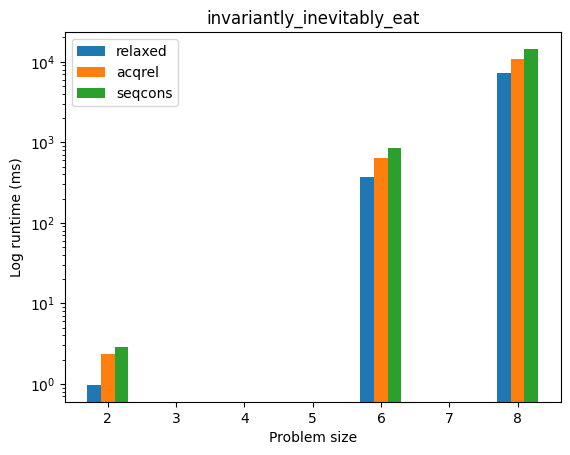

Seqcons/Rlx:
problem size
2    2.973400
6    2.261837
8    1.979676
Name: runtime (ms), dtype: float64
Seqcons/AcqRel:
problem size
2    1.227402
6    1.331283
8    1.339665
Name: runtime (ms), dtype: float64
AcqRel/Rlx:
problem size
2    2.422516
6    1.698990
8    1.477740
Name: runtime (ms), dtype: float64


In [15]:
tot_width = 0.6;
orders = ["relaxed", "acqrel", "seqcons"];
width =  tot_width / len(orders);

for f, rows in per_formula:
    if f != "invariantly_inevitably_eat":
        continue;
        
    offset = - 0.5 * tot_width + 0.5 * width;
    plt.figure();
    plt.title(f"{f}")
    ys = [];
    for o in orders:
        o_rows = rows[rows["memorder"] == o];
        Y = o_rows.groupby("problem size")["runtime (ms)"].mean();
        ys.append(Y);
        plt.bar(Y.index + offset, Y.values, width, label=o);
        offset += width;
    plt.legend();
    plt.xlabel("Problem size");
    plt.ylabel("Log runtime (ms)");
    plt.yscale("log");
    plt.show();
    
print(f"Seqcons/Rlx:");
print(ys[2]/ys[0]);

print(f"Seqcons/AcqRel:");
print(ys[2]/ys[1]);

print(f"AcqRel/Rlx:");
print(ys[1]/ys[0]);

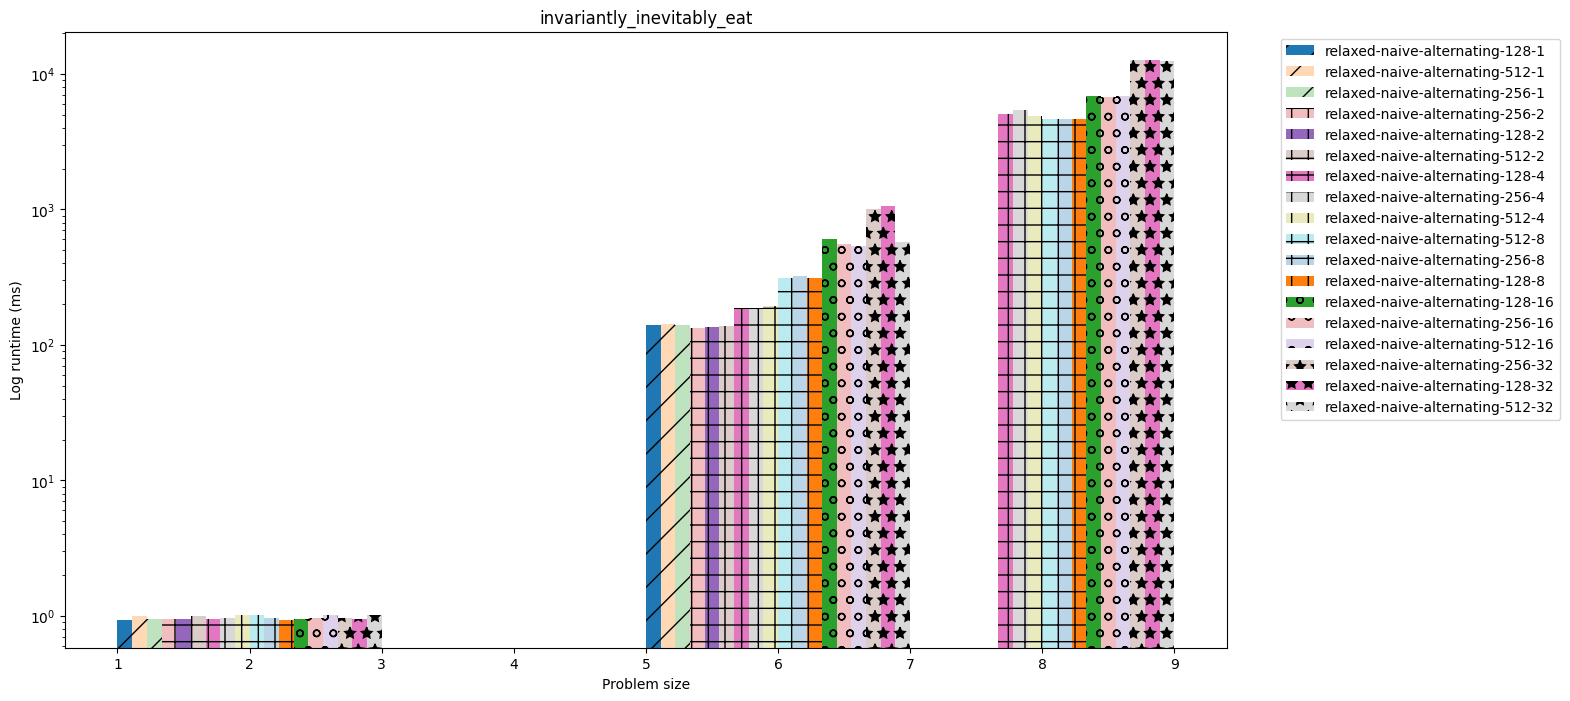

In [14]:
tot_width = 2;

for f, rows in per_formula:
    if f != "invariantly_inevitably_eat":
        continue;
        
    configs = rows.sort_values(by=['ipt'])["config"].unique();
    configs = [c for c in configs if c.startswith("relaxed")];
    width =  tot_width / len(configs);
    offset = - 0.5 * tot_width + 0.5 * width;
    
    plt.figure(figsize=(15,8));
    plt.title(f"{f}")
    ys = [];
    for c in configs:
        c_rows = rows[rows["config"] == c];
        X = c_rows["problem size"];
        Y = c_rows["runtime (ms)"];
        if c_rows["ipt"].iloc[0] == 1:
            h = '/';
        elif c_rows["ipt"].iloc[0] == 16:
            h = 'o';
        elif c_rows["ipt"].iloc[0] == 32:
            h = '*';
        else:
            h = '+';
        
        if c_rows["tpb"].iloc[0] == 128:
            a = 1;
        else:
            a = 0.3;
        
        plt.bar(X + offset, Y, width, label=c, hatch=h, alpha=a);
        offset += width;
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.xlabel("Problem size");
    plt.ylabel("Log runtime (ms)");
    plt.yscale("log");
    plt.show();


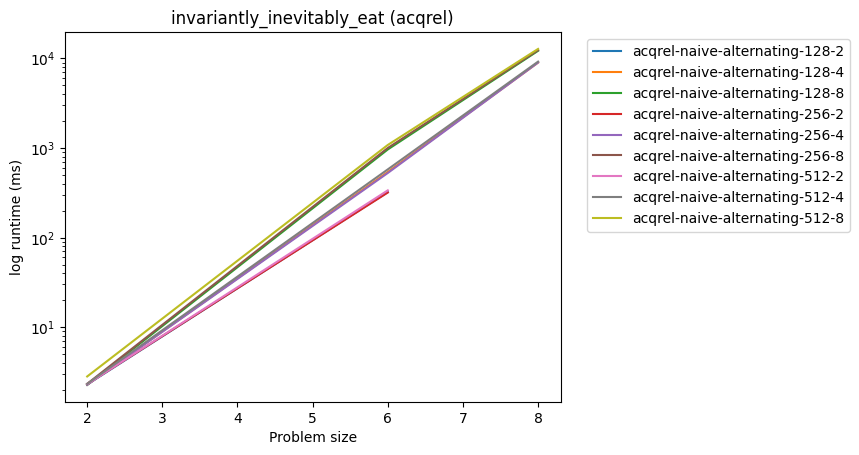

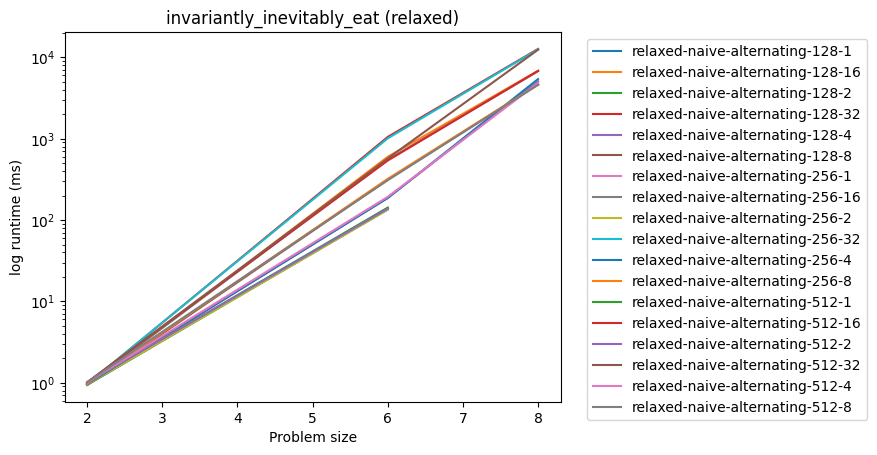

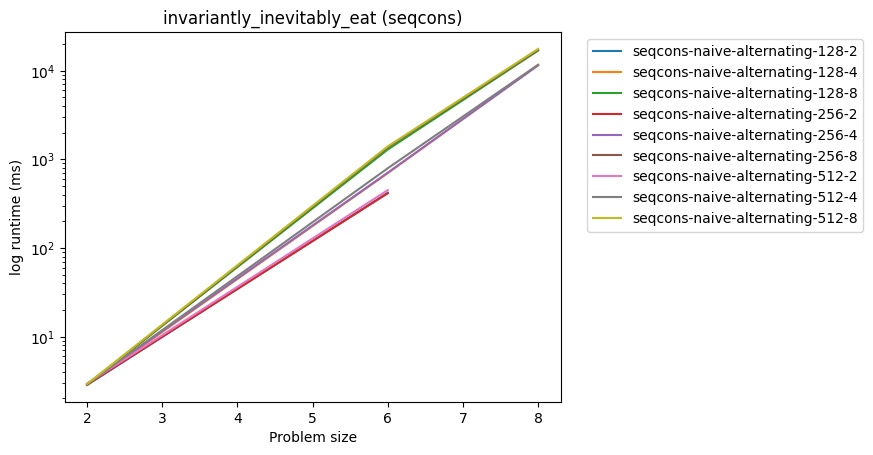

In [7]:


for f, rows in per_formula:
    if f != "invariantly_inevitably_eat":
        continue;
    per_order = rows.groupby("memorder");
    for o, points in per_order:
        plt.figure();
        plt.title(f"{f} ({o})");
        per_conf = points.groupby("config");
        for c, points in per_conf:
            head = points.iloc[0];
            X = points["problem size"].astype(int);
            Y = points["runtime (ms)"].astype(float);
            plt.plot(X, Y, label = c);
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
        plt.xlabel("Problem size");
        plt.ylabel("log runtime (ms)");
        plt.yscale("log");
        plt.show();